# Reinforcement Learning for Continuous Control

---

This notebook describes the implementation of the Deep Reinforcement Learning agent used to solve the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

This notebook also serves as live and executable documentation. Therefore, there will be a little bit of code and modules imported.

Nevertheless, all the *important* stuff is implemented in the [deeprl](deeprl/) package. So, you are encouraged to take a look at that package as well. A fully trained agent should perform as in the video below (if the video doesn't show automatically, execute the cell manually).

In [1]:
%%HTML
<iframe width="560" height="315"
 src="https://www.youtube.com/embed/B4JKTivr4qA"
    frameborder="0"
    allow="autoplay; encrypted-media" allowfullscreen>
</iframe>

## 1. Loading necessary packages

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the [README](README.md) instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md), [NumPy](http://www.numpy.org/), and [PyTorch](http://pytorch.org).

If you are running a Windows system, please pay special attention to the README, as the code **will not** be able to automatically execute the environment.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

from deeprl.train import ddpg
from deeprl.agent import DDPGAgent
from deeprl.model import DDPGActor, DDPGCritic

from deeprl.util import print_source
from deeprl.util import load_environment

## 2. The algorithm

As aforementioned, this code uses Deep Reinforcement Learning to solve the environment. In particular, we use the Deep Deterministic Policy Gradient (DDPG) algorithm. This algorithm can be seen as an extension of the Deep Q Networks (DQN) algorithm for continuous action spaces.

DDPG uses *experience replay* and *fixed Q-targets* to be able to "stabilize" the learning process and an actor-critic-ish setup. Overall, the algorithm is:

 * Take action $a_t = \mu(s_t, | \theta^\mu) + \mathcal{N}_t$ according to the current policy and exploration noise
 * Store transition $(s_t, a_t, r_{t+1}, s_{t+1})$ in replay memory $\mathcal{D}$
 * Sample random mini-batch of transitions $(s, a, r, s')$ from $\mathcal{D}$
 * Set $y_i = r_i + \gamma Q'(s_{i+1}, \mu'(s_{i+1}|\theta^{\mu'})|\theta^{Q'})$
 * Update critic by minimizing the loss: $\mathcal{L}=\frac{1}{N}\sum_i\left(y_i-Q(s_i, a_i|\theta^Q)\right)^2$
 * Update the actor policy using the sampled policy gradient:
$$
\nabla_{\theta^\mu}J\approx\frac{1}{N}\sum_i\nabla_a Q(s, a | \theta^Q)|_{s=s_i,a=\mu(s_i)}\nabla_{\theta^\mu}\mu(s|\theta^\mu)|_{s_i}
$$
 * Update the target networks:
$$
\theta^{Q'} \leftarrow \tau\theta^Q + (1-\tau)\theta^{Q'}\\
\theta^{\mu'} \leftarrow \tau\theta^\mu + (1-\tau)\theta^{\mu'}
$$

### 2.1 The optimizer

The variant of stochastic gradient descent we use is the [Adam optimization algorithm](https://arxiv.org/abs/1412.6980).

### 2.2 The network architecture

For this problem, we're using three-layer fully-connected neural networks for both the actor and the critic.

In [2]:
print_source(DDPGActor.__init__)
print_source(DDPGActor.forward)

```python
    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(DDPGActor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

```

```python
    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))

```

In [3]:
print_source(DDPGCritic.__init__)
print_source(DDPGCritic.forward)

```python
    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(DDPGCritic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

```

```python
    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

```

### 2.3 The actual learning algorithm

With the textual description given above and having the network and optimizer defined, one can devise a learning algorithm written in PyTorch.  The algorithm can be implemented as below (again, the reader is encouraged to read the [full source](deeprl/agent.py)).

Notice that we *do not* fully transition the local weights $w$ to the $w^-$ weights. Rather, we perform a *soft* update, controlled by hyperparameter $\tau$. This allows us to slowly transition from set of weights to the other, giving more smooth operation to the algorithm.

In [4]:
print_source(DDPGAgent.learn)

```python
    def learn(self, experiences, gamma=GAMMA, tau=TAU):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        :param experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
        :param gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, tau)
        self.soft_update(self.actor_local, self.actor_target, tau)

```

### 2.4 Hyperparameters

As can be seen above, the algorithm has many hyperparameters. The set of hyperparameters used are:

 * $\gamma = 0.99$ (Discount factor)
 * $\tau = 1\times10^{-3}$ (Network soft-update parameter)
 * $\alpha = 1\times10^{-3}$ (Actor learning rate)
 * $\beta = 1\times10^{-3}$ (Actor learning rate)
 * Batch size = 128
 * $|\mathcal{D}| = 1\times10^{5}$ (Size of the replay buffer)
 * Period between target updates = 2 (every 2 episodes we perform the soft update
 * Number of updates: 1
 
## 3 Training and evaluation

We have decided to train and evaluate the technique using 20 different Reacher agents. To do so, we instantiated 20 *different* DDPG networks to train the agents. All networks shared the same memory buffer, but had independent weights.

After each episode, we computed the cumulative rewards of all the agents in that episode and too its average. This gave us the current score given below.

We also kept a moving average of the aforementioned metric over 100 episodes, which is what we call the "average" score.

This is in line with the specification of the environment:

> The barrier for solving the second version of the environment is slightly different, to take into account the presence of many agents. In particular, your agents must get an average score of +30 (over 100 consecutive episodes, and over all agents).

> Specifically, After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 20 (potentially different) scores. We then take the average of these 20 scores. This yields an average score for each episode (where the average is over all 20 agents).


### 3.1 Training

With all of the above defined, we can train our agent. Training is performed by the `ddpg` function, shown below.

What it does, essentially, is to load the environment, configure the agent with the environment parameters, and execute the learning process.

The optimization criterion we're using is achieving an average reward for all agents greater than 30 over 100 episodes.

In [5]:
print_source(ddpg)

```python
def ddpg(env, n_episodes=2000, max_t=1000, checkpointfn='checkpoint.pth', load_checkpoint=False,
         update_every=2, n_updates=1, solution_threshold=30.0):
    '''Runs DDPG in an environment'''

    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=True)[brain_name]

    action_size = brain.vector_action_space_size
    n_agents = len(env_info.agents)
    states = get_state(env_info, n_agents=n_agents)
    state_size = len(states) if n_agents == 1 else len(states[0])

    if load_checkpoint:
        try:
            agents = [Agent.load(checkpointfn) for _ in range(n_agents)]
        except Exception:
            logging.exception('Failed to load checkpoint. Ignoring...')
            agents = [Agent(state_size, action_size, 0) for _ in range(n_agents)]
    else:
        agents = [Agent(state_size, action_size, 0) for _ in range(n_agents)]

    for i_episode in range(1, n_episodes + 1):
        for agent in agents:
            agent.episode += 1

        env_info = env.reset(train_mode=True)[brain_name]
        states = get_state(env_info, n_agents=n_agents)
        scores = np.zeros(n_agents)

        for t in range(max_t):
            actions = np.vstack([agent.act(state) for agent, state in zip(agents, states)])

            env_info = env.step(actions)[brain_name]
            next_states = get_state(env_info, n_agents=n_agents)
            rewards = env_info.rewards
            dones = env_info.local_done

            for i in range(n_agents):
                agents[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i], learning=False)

            if len(agent.memory) > BATCH_SIZE and t and t % update_every == 0:
                for i in range(n_agents):
                    for j in range(n_updates):
                        experiences = agents[i].memory.sample()
                        agents[i].learn(experiences)

            states = next_states
            scores += rewards

            if any(dones):
                break

        # Store scores for all agents
        [agent.scores.append(score) for agent, score in zip(agents, scores)]

        avg_score = np.mean([agent.scores[-100:] for agent in agents])

        logging.debug(
            'Episode {}\tAverage Score: {:.3f}\tCurrent (avg) Score: {:.3f}'
                .format(i_episode, avg_score, np.mean(scores))
        )

        if i_episode % 100 == 0:
            logging.info(
                'Episode {}\tAverage Score: {:.3f}'
                    .format(i_episode, avg_score)
            )
            logging.info(
                'Saving checkpoint file...'
            )
            [agent.save(checkpointfn % i) for i, agent in enumerate(agents)]

        if np.mean(avg_score) >= solution_threshold:
            logging.info(
                'Environment solved in {:d} episodes!'
                    .format(i_episode - 99)
            )
            logging.info(
                'Saving checkpoint file at %s', checkpointfn
            )
            [agent.save(checkpointfn % i) for i, agent in enumerate(agents)]
            if i_episode > 100:
                break

    return agents

```

### 3.2 Evaluation

The model was trained previously in an offline non-Jupyter setting. It was invoked with code similar to the following:

```python
env = load_environment()
agents = ddpg(env, checkpointfn='checkpoint-%d.pth')
env.close()
```

In the cell below we load the log file generated by the training process and plot the agent's performance.

In [10]:
avgs = []
curs = []
with open('training.log') as fp:
    for line in fp:
        if 'Episode' not in line or 'DEBUG' not in line:
            continue
        line = line.split(':')
        avgs.append(float(line[3].split()[0].strip()))
        curs.append(float(line[-1].strip()))

In [11]:
# For some perspective, the head of the log is shown below:
!head training.log

DEBUG:root:Episode 1    Average Score: 0.572    Current (avg) Score: 0.572 
DEBUG:root:Episode 2    Average Score: 0.575    Current (avg) Score: 0.578 
DEBUG:root:Episode 3    Average Score: 0.636    Current (avg) Score: 0.758 
DEBUG:root:Episode 4    Average Score: 0.677    Current (avg) Score: 0.800 
DEBUG:root:Episode 5    Average Score: 0.707    Current (avg) Score: 0.828 
DEBUG:root:Episode 6    Average Score: 0.703    Current (avg) Score: 0.681 
DEBUG:root:Episode 7    Average Score: 0.697    Current (avg) Score: 0.660 
DEBUG:root:Episode 8    Average Score: 0.697    Current (avg) Score: 0.695 
DEBUG:root:Episode 9    Average Score: 0.698    Current (avg) Score: 0.712 
DEBUG:root:Episode 10   Average Score: 0.720    Current (avg) Score: 0.913 


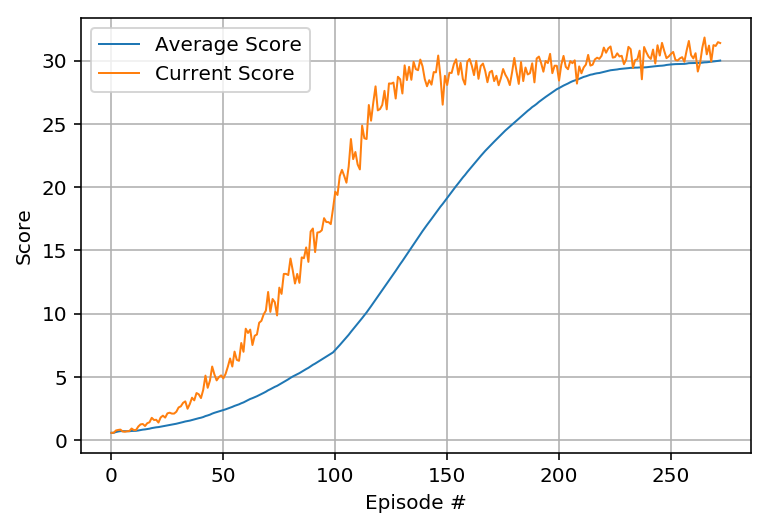

In [12]:
fig = plt.figure()
plt.plot(np.arange(len(avgs)), avgs, linewidth=1.0, label='Average Score')
plt.plot(np.arange(len(curs)), curs, linewidth=1.0, label='Current Score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.grid()
plt.show()

In [13]:
# The total number of episodes is shown below:
!tail training.log

DEBUG:root:Episode 266  Average Score: 29.868   Current (avg) Score: 31.835
DEBUG:root:Episode 267  Average Score: 29.876   Current (avg) Score: 30.501
DEBUG:root:Episode 268  Average Score: 29.896   Current (avg) Score: 31.195
DEBUG:root:Episode 269  Average Score: 29.912   Current (avg) Score: 29.929
DEBUG:root:Episode 270  Average Score: 29.934   Current (avg) Score: 31.232
DEBUG:root:Episode 271  Average Score: 29.953   Current (avg) Score: 31.165
DEBUG:root:Episode 272  Average Score: 29.984   Current (avg) Score: 31.466
DEBUG:root:Episode 273  Average Score: 30.010   Current (avg) Score: 31.397
INFO:root:Environment solved in 174 episodes!
INFO:root:Saving checkpoint file at checkpoint-%d.pth


## 4 Future ideas

Although the agent exhibits decent performance learning the environment successfully, it can be greatly improved. Some of them are outlined below.

 * The very first thing to try would be to perform hyperparameter optimization, either by performing grid search or random search, or, more interestingly and more aligned with the techniques studied here: Bayesian Optimization! Properly tuned hyperparameters would probably improve the agent's performance
 * Orthogonal to hyperparameter optimization, other improvements would be:
   * Implementing PPO
   * Implementing TRPO (I'm particularly interested in this one)
 * The agent converges to the expected 30 performance quite slowly. A few changes in the model would probably help it learn.